In [1]:
import numpy as np
import numpy.random as npr
from tqdm import tqdm
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
num_steps = 1000

In [6]:
v0 = 10 * tf.to_float([1., 1.]) / 1.4142135623730951
r0 = tf.to_float([0., 0.])

init_state = tf.concat([r0, v0], 0)
init_state

<tf.Tensor: id=8, shape=(4,), dtype=float32, numpy=array([0.      , 0.      , 7.071068, 7.071068], dtype=float32)>

In [7]:
class CannonODE(tf.keras.Model):
    def call(self, inputs, **kwargs):
        r_vec, v_vec = inputs[:2], inputs[2:]
        v_length = tf.sqrt(tf.reduce_sum(v_vec**2)) + 1e-6
        vn = v_vec / v_length
        g_vec = tf.to_float([0, -10])
        return tf.concat([v_vec, - 10.5 * vn + g_vec], 0)

    def compute_output_shape(self, input_shape):        
        return input_shape

In [8]:
from neural_ode import NeuralODE

In [9]:
neural_ode = NeuralODE(CannonODE(), tmax=2.0, num_steps=num_steps)
target_state, states_history = neural_ode.forward(init_state, return_states="numpy")
target_state.numpy()

array([ 2.8883400e+00,  8.4779024e-02,  5.6787218e-07, -6.7263579e-01],
      dtype=float32)

In [10]:
trajectory = np.stack(states_history)
trajectory.shape

(1001, 4)

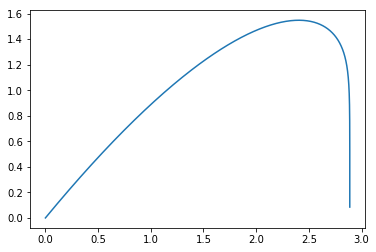

In [11]:
x, y = trajectory[:, 0], trajectory[:, 1]
plt.plot(x, y)

In [12]:
v0 = tf.to_float([0., 0.])
r0 = tf.to_float([2., 0.])
target_state = tf.concat([r0, v0], 0)

In [13]:
opt_neural_ode = NeuralODE(CannonODE(), tmax=2.0, num_steps=num_steps // 10)
optimizer = tf.train.MomentumOptimizer(learning_rate=0.05, momentum=0.9)

In [14]:
start_state = tf.Variable(init_state, name="start_state")
start_state

<tf.Variable 'start_state:0' shape=(4,) dtype=float32, numpy=array([0.      , 0.      , 7.071068, 7.071068], dtype=float32)>

In [15]:
loss_history = []
for step in tqdm(range(50)):
    with tf.GradientTape() as g:    
        g.watch(start_state) 
        end_state = opt_neural_ode.forward(start_state, return_states=False)
        loss = tf.reduce_sum(tf.square(end_state[:2] - target_state[:2]))

    dLoss = g.gradient(loss, start_state)    
    dLoss = tf.to_float([0.0, 0.0, dLoss[2], dLoss[3]])    
    optimizer.apply_gradients([(dLoss, start_state)])
    loss_history.append(loss)

100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


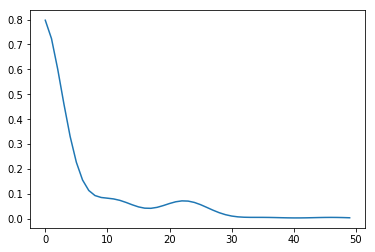

In [16]:
plt.plot(loss_history)

In [18]:
opt_target_state, opt_states_history = neural_ode.forward(start_state, return_states="numpy")
opt_trajectory = np.stack(opt_states_history)
opt_target_state.numpy()

array([ 2.0582778e+00, -3.7424196e-04,  2.3893548e-10, -3.8613153e-01],
      dtype=float32)

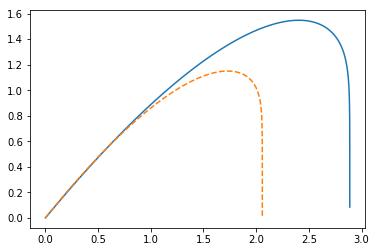

In [19]:
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.plot(opt_trajectory[:, 0], opt_trajectory[:, 1], "--")

In [20]:
optimizer = tf.train.MomentumOptimizer(learning_rate=0.05, momentum=0.9)
start_state = tf.Variable(init_state, name="start_state")

In [21]:
loss_history = []
for step in tqdm(range(50)):    
    end_state = opt_neural_ode.forward(start_state)
    with tf.GradientTape() as g:            
        g.watch(end_state) 
        loss = tf.reduce_sum(tf.square(end_state[:2] - target_state[:2]))
    
    dLoss = g.gradient(loss, end_state)
    h_start, dfdh0, dWeights = opt_neural_ode.backward(end_state, dLoss)
    dLoss = tf.to_float([0.0, 0.0, dfdh0[2], dfdh0[3]])    
    optimizer.apply_gradients([(dLoss, start_state)])
    loss_history.append(loss)

100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


In [22]:
opt_adjoint_target_state, opt_adjoint_states_history = neural_ode.forward(start_state, return_states="numpy")
opt_adjoint_trajectory = np.stack(opt_adjoint_states_history)
opt_adjoint_target_state.numpy()

array([ 2.0545859e+00, -6.6174893e-03,  2.4007885e-10, -3.8643748e-01],
      dtype=float32)

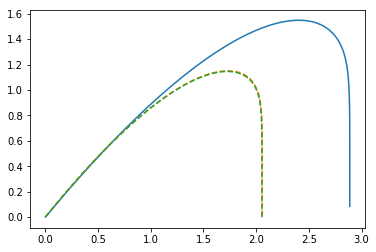

In [23]:
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.plot(opt_trajectory[:, 0], opt_trajectory[:, 1], "--")
plt.plot(opt_adjoint_trajectory[:, 0], opt_adjoint_trajectory[:, 1], "--")

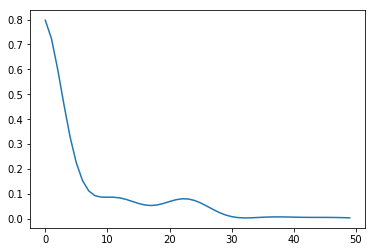

In [24]:
plt.plot(loss_history)

In [25]:
opt_neural_ode = NeuralODE(CannonODE(), tmax=2.0, num_steps=num_steps // 10)
opt_neural_ode.defun()

In [26]:
optimizer = tf.train.MomentumOptimizer(learning_rate=0.05, momentum=0.9)
start_state = tf.Variable(init_state, name="start_state")

In [30]:
loss_history = []
for step in tqdm(range(50)):    
    end_state = opt_neural_ode.forward(start_state)
    with tf.GradientTape() as g:            
        g.watch(end_state) 
        loss = tf.reduce_sum(tf.square(end_state[:2] - target_state[:2]))    
    dLoss = g.gradient(loss, end_state)    
    h_start, dfdh0, dWeights = opt_neural_ode.backward(end_state, dLoss)
    dLoss = tf.to_float([0.0, 0.0, dfdh0[2], dfdh0[3]])    
    optimizer.apply_gradients([(dLoss, start_state)])
    loss_history.append(loss)

100%|██████████| 50/50 [00:02<00:00, 23.81it/s]


In [31]:
opt_adjoint_target_state, opt_adjoint_states_history = neural_ode.forward(start_state, return_states="numpy")
opt_adjoint_trajectory = np.stack(opt_adjoint_states_history)
opt_adjoint_target_state.numpy()

array([ 2.0014355e+00, -5.8008917e-03,  1.0240083e-10, -3.6546654e-01],
      dtype=float32)

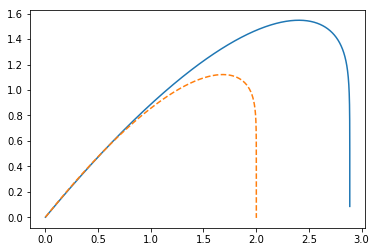

In [32]:
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.plot(opt_adjoint_trajectory[:, 0], opt_adjoint_trajectory[:, 1], "--")